## Final Project W261 - Spring, 2019 (Saturday Sections)
Kyle Chuang
Siobhan Harrington
Tracy Huang
Hannah Morgan
Nathan Nam


## I. Introduction and Question Formulation

In just a few short decades, internet advertising has become an $80 billion industry and surpassed television advertising in terms of revenue.  As consumers spend more and more time online, companies have followed their customers and communicate with them through web banners, frame ads, pop ups, and email.  Internet advertising is attractive to companies because it is generally low cost, targetable, and measurable. Companies can target consumers based on browser history, cookies stored on their computer, and user preferences.  As individual digital footprints increase, there is more and more data for online advertisers to use to predict which ads will result in success.  

The success of these endeavors can be measured in a variety of ways.  Firstly, they can measure the click through rate (CTR).  Did the potential customer click on the advertisement that was displayed?  Secondly, they can measure what level of interaction the consumer had.  How long did the potential customer stay on the website?  Did the potential customer interact with the website?  Did the potential customer purchase the item (also known as the conversion rate)?  These measurements allow companies to better understand the impact of the online ad as compared with a television or newspaper ad. However, the latency of a metric like a conversion rate (for example, the customer could come back later after thinking about it and then purchase the product) makes it more difficult to track, while the click through rate requires less latency to track. 

The online advertising field, with a wealth of knowledge about users and a straight forward method to track the success of the ads, lends itself to the machine learning field.  In 2005, Criteo was founded to help companies "deliver the right ad at the right moment".  In 2014, Critero decided to crowdsource the machine learning capabilities in advertising through a Kaggle Competition.  Critero released 44 million records of traffic logs to the Kaggle community and offered up to $10,000 in prize money to the winning team.  The request was straight forward: use the unlabeled data to determine a probability that the user will click through to the ad.  The data provided included advertiser information, user information, ad metadata, and user/advertiser interaction history.  However, the hashed data made it impossible to tell what column contained what data category.  Each team was required to submit the results of a test file with the predicted probability for every record and to agree to release their source code.

This kaggle competition had several challenging aspects and questions to ponder:

1.  How do we approach a dataset without any context?  The training set includes 1 label field, 13 numeric fields, and 26 hashed categorical fields.  It was impossible to apply any industry acumen or logical interpretation/bias to the data. 

2.  How do we approach modeling such an enormous dataset (44 million records) with so many potential features?  The categorical data contained over 33 million unique values across the 26 columns.  How do we understand the interaction of so many variables when we are not sure what they mean?

3. Can we accurately predict if the user will click on this ad?  This is the ultimate question of the challenge.

4. How do we measure success of the model we build?

The first question is addressed in our approach to pre-processing of the data. Since no contextual information was given, we utilized properties of the data itself to remove features and edit variables. Dealing with the large amount of data required utilizing skills learned in class, including partitioning and serializing the data, utilizing Spark, and running the code on a GCP instance. Questions 3, successfully predicting click through rate, we did our best to answer through our algorithm design. How that success is measured we decided was a good fit for the log-loss method.  


Sources Used:

* https://en.wikipedia.org/wiki/Online_advertising 
* https://www.washingtonpost.com/apps/g/page/business/how-targeted-advertising-works/412/??noredirect=on
* https://www.criteo.com/
* https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/9568#latest-49996
    

## II. Algorithm Theory

A linear modeling technique is great and does well in a variety of problems but the drawback is that the model only learns the effect of all variables or features individually rather than in combination and non-linear features are missed. Therefore, while we use logistic regression as a baseline (since it is the better regression model for boolean classification) the model we chose to more fully develop for click through rate is decision tree modeling and random forest. Some other pros to decision tree modeling include its ability to easily handle categorical data with little preprocessing, handles missing values well, is easily scalable, and is one of the most accurate modeling techniques out there. Furthermore, it is able to model non-linear functions. 

A classification decision tree model breaks the data down into a series of decisions based upon the the features that branch out until the stopping criteria is met. At a high level, the model starts with a root node, and the feature assigned to that root node is split to create an edge, and that edge spawns either another internal node or returns a leaf node or terminal node with one of the classification decisions attached to it. For each record, we follow the tree until a termination node is reached, and then our prediction is the value of that node. 

Sources: 

* https://www.analyticsvidhya.com/blog/2018/01/factorization-machines/?utm_campaign=buffer&utm_content=buffer81252&utm_medium=social&utm_source=twitter.com 

<img src="ToyDT21.jpeg">


Technically, how is this done? The algorithm for Decision Tree learning follows a recursive binary splitting approach that is top down and greedy [6]. It is top down because the data all starts at the root node and then works its way down the tree, and it is greedy because at each node the best decision for the moment is made, not the best decision for overall minimum loss. Several ways to know when to stop splitting the data and creating a terminal node are:

* All of the training data in that node is of the same classification
* There are less than a certain number of records in that node
* A certain number of layers of nodes have been created

The next thing to look at is how features are chosen and split for nodes. This is done using information gain or Gini index. The difference in entropy before and after the split gives us the quality of the split and the information gain of the split - the most desirable split at that time is the one with the highest information gain.

$H(X)=-\sum p(x)log(p(x))$


Information Gain = H(parent node) - weighted average H(children)

The Gini index is very similar to Information gain. and the equation is shown below. It is a measure of the purity of the split - if the Gini index is 0, then the data is split perfectly. The $\hat{p}$ below represents the proportion of training observations in that classification.

$G = \sum \hat{p}(1-\hat{p})$

Misclassification error can also be used. Gini index and information gain/entropy are better measurements since they optimize the probabilities, which theoretically, should optimize the misclassification and generalize better. For unordered categorical features that have many more than two variables, which is almost all of our categorical variables (because of the hash we don't know if there exists a natural order), Breiman's theorem is utilized to reduce the number of split comparisons. Essentially, the unique variables in the feature are sorted by the average classification value, and splits are only calculated in that order. Instead of $2^n$ number of split comparisons, only n split comparisons need to be evaluated



While decision tree modeling is a great method, it does tend to overfit the training data and become not very generalizable. Therefore, we want to introduce an ensemble method to make it better, called random forest. Essentially, the random forest algorithm makes a specified number of decision tree models with a random selection of features. Then, the data is fed to all of those trees, and the highest percentage output decision is chosen as the final decision. Random forest is a highly effective method because it reduces the bias without significantly increasing the variance. 

Random forests are a popular ensemble model that have won many kaggle competitions over the years. Thanks to the Google project, PLANET - the spark ML library has a highly parallelizable method for decision trees. In this toy example, we will walk through what the PLANET drive code is doing under the hood.

Below is a high level diagram of the process. A decision tree run in parallel with the PLANET methodology can be broken into three parts.

1. "Initialization" - this step explores the continuous variables and identifies good split points. It is only run one time per decision tree. The information is returned to the controller, and the controller will pass this information onto every subsequent job.

2. "FindBest" is the most complex step. It will read through all the data in parallel and use Breimann's algorithm to calculate the best split

3. "InMemory" works in much the same way as "FindBest", but the controller will only invoke this step if there is a node within the tree that can easily fit in memory. "InMemory" skips the parallelization steps to save on overhead when it is not required. Our toy example will surely pass through this part of the framework.

This diagram is slightly misleading since the controller communicates with each phase, but for visual clarity- we omitted all the arrows.

Each decision tree is run in parallel, and then each step can use multiple mappers and reducers to work through subsets of the total data. This highly paralleiizable approach has enabled data scientists to run huge datasets through Random Forest with only commercially available hardware. 


<img src="ToyHighLevel21.jpeg">

Now, that we understand the high level flow, let's dig into what is happening under the hood.


<img src="ToyLowLevel21.jpeg">

The initialization phase runs once per decision tree.  This parallelized phase helps the algorithm break up the continuous variables into viable split points.  It runs this process one time to aggregate each continuous feature into equal groups so the next phase can use this metadata many times.  

Find Best Splits runs one time for each decision tree level.  It is also highly parallelized - partitioning based on parent node.  The controller/master node maintains the current Decision Tree Diagram.  This information is sent to the Mappers along with a data subset and the continuous variable split points produced by the initialization phase.  The mappers process the data in parallel. There are two types of outputs from each mapper - Ordered Attributes(continuous variables) or Unordered Attributes (categorical data).  The output is slightly different since the Ordered attributes maintain the split value as part of the key.  The reducer will determine the purity and output the results back to the controller.  The controller will add this information into the decision tree and repeat the process until we have reached a stopping point (based on criteria described earlier).

The In Memory process follows very similar steps except it is not done in parallel.  The controller recognizes that the group of records that need to be processed for that node is small enough to run on a single mapper/reducer.

In order to better understand what is actually happening in the Reducer step of the job, we have a toy example with a much simpler version of our data.  There is only a categorical variable and one continuous variable in this dataset.  The process will use GINI to decide which variable to break on.

The categorical variable broke the data up into 7 and 3 records with a better click through rate on the smaller dataset. 

The continuous dataset was divided in half to explore the impact of this decision point.  The GINI calculation showed that while this produced a pure node, it was more effective to start with the division on the categorical variable.

Sources: 

* https://databricks.com/blog/2015/01/21/random-forests-and-boosting-in-mllib.html
* http://static.googleusercontent.com/media/research.google.com/en/us/pubs/archive/36296.pdf
   

<img src="ToyGINIDiagram21.jpeg">

## III. EDA

While this kaggle challenge provided very little metadata or context, we can take a look at the data itself to answer some of our design questions.  Namely:

1.  How many columns of data are well populated?  If a column is largely null, this field could be a good candidate for pruning.

2.  How are the features distributed within the columns?  When we one-hot-encode this data, this will tell us how sparse our matrix will be.  Additionally, if a specific feature (value within a column) only occurs a handful of times, then including this variable may lead to overfitting our training data.

3.  Are there any correlations among our numeric values?  In other words, could we remove any numeric columns because the values are redundant or close to redundant?

Other notes on data quality: all records have a label of 0 or 1, and all categorical/numerical columns contain all the same data type. There are some null values throughout, and they are addressed later. 

Before we dig into the details of the EDA, we need to load up the data. This cell prints out a schema of the data so we can understand the raw format.

In [1]:
#Housekeeping to get ready to use the dataset:
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt
#from plotnine import *
from pyspark.mllib.stat import Statistics
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SQLContext, Row
from pyspark.sql import HiveContext, Row
import pyspark.sql.functions as F
from pyspark.sql import types
from pyspark.sql.functions import lit
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, split
from functools import reduce
from pyspark.sql.functions import col, lit, when

from pyspark.ml.feature import OneHotEncoder, StringIndexer

from pyspark.sql import SparkSession
app_name = "w261FinalProject_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

!rm -r train.parquet

traindf = spark.read.option("delimiter", "\t").csv("gs://w261-final-nathan/data/train.txt")

for i in range(0,15):
    traindf=traindf.withColumn('_c'+str(i),traindf['_c'+str(i)].cast('integer'))
traindf = traindf.withColumnRenamed("_c0", "label")
for i in range(1,40):
    traindf = traindf.withColumnRenamed("_c"+str(i), "_"+str(i+1))
traindf.printSchema()

traindf.write.parquet('gs://w261-final-nathan/data/train2.parquet')
traindf2=spark.read.parquet('gs://w261-final-nathan/data/train2.parquet')


rm: cannot remove 'train.parquet': No such file or directory
root
 |-- label: integer (nullable = true)
 |-- _2: integer (nullable = true)
 |-- _3: integer (nullable = true)
 |-- _4: integer (nullable = true)
 |-- _5: integer (nullable = true)
 |-- _6: integer (nullable = true)
 |-- _7: integer (nullable = true)
 |-- _8: integer (nullable = true)
 |-- _9: integer (nullable = true)
 |-- _10: integer (nullable = true)
 |-- _11: integer (nullable = true)
 |-- _12: integer (nullable = true)
 |-- _13: integer (nullable = true)
 |-- _14: integer (nullable = true)
 |-- _15: integer (nullable = true)
 |-- _16: string (nullable = true)
 |-- _17: string (nullable = true)
 |-- _18: string (nullable = true)
 |-- _19: string (nullable = true)
 |-- _20: string (nullable = true)
 |-- _21: string (nullable = true)
 |-- _22: string (nullable = true)
 |-- _23: string (nullable = true)
 |-- _24: string (nullable = true)
 |-- _25: string (nullable = true)
 |-- _26: string (nullable = true)
 |-- _27: strin

#### III.A NULLS Analysis

First, we will explore how much of our data is not actually populated. Columns with very little data are good candidates for feature reduction. For example, column _15 has less than 2% of the rows populated.  Every column has at least some data. 


In [77]:
#Number of null values out of 44,000,000
tot=traindf2.count()
print('Total Number of Records:', tot)
x= traindf2.filter("label is NULL").count()
print ('label:', str(x/tot*100) + '%')
for i in range(2,41):
    x= traindf2.filter("_"+str(i) + " is NULL").count()
    print ('_'+str(i)+':', str(x/tot*100) + '%')

Total Number of Records: 45840617
label: 0.0%
_2: 45.360550011794125%
_3: 0.0%
_4: 21.46447330759095%
_5: 21.67808736082239%
_6: 2.580936028849699%
_7: 22.36516144623446%
_8: 4.325565687739325%
_9: 0.049678650704025204%
_10: 4.325565687739325%
_11: 45.360550011794125%
_12: 4.325565687739325%
_13: 76.50780965709951%
_14: 21.67808736082239%
_15: 98.01545428587927%
_16: 0.0%
_17: 3.4019459205795592%
_18: 3.4019459205795592%
_19: 0.0%
_20: 12.086715586747012%
_21: 0.0%
_22: 0.0%
_23: 0.0%
_24: 0.0%
_25: 0.0%
_26: 3.4019459205795592%
_27: 0.0%
_28: 0.0%
_29: 0.0%
_30: 3.4019459205795592%
_31: 0.0%
_32: 0.0%
_33: 44.00651500829494%
_34: 44.00651500829494%
_35: 3.4019459205795592%
_36: 76.25349588990044%
_37: 0.0%
_38: 3.4019459205795592%
_39: 44.00651500829494%
_40: 44.00651500829494%


#### III.B How are the features distributed within the data set?
Because continuous numeric variables are modeled very differently from categorical data, we will seek to understand the distributions of these two types of data differently. First, we'll start with the numeric data using a two percent sample. Almost all our data ranges start at zero with the exception of column 3 and column 15.  For many columns the standard deviation and range of the data is fairly tight, but there are a handful of columns with a wide spread between the minimum and the maximum. 

In [64]:
df=traindf2.sample(False,0.02).toPandas()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,917802.0,2.564856e-01,4.366932e-01,0.0,0.0,0.0,1.0,1.0
_2,500884.0,3.485675e+00,9.101944e+00,0.0,0.0,1.0,3.0,703.0
_3,917802.0,1.053090e+02,3.901994e+02,-2.0,0.0,3.0,35.0,30363.0
_4,720357.0,2.669778e+01,3.867813e+02,0.0,2.0,6.0,18.0,65535.0
_5,718194.0,7.329425e+00,8.819909e+00,0.0,2.0,4.0,10.0,778.0
_6,894054.0,1.865574e+04,6.995584e+04,0.0,329.0,2825.0,10149.0,2325853.0
_7,712059.0,1.155613e+02,3.258102e+02,0.0,8.0,33.0,103.0,42865.0
_8,877964.0,1.637293e+01,6.566547e+01,0.0,1.0,3.0,11.0,7234.0
_9,917330.0,1.250606e+01,1.594085e+01,0.0,2.0,7.0,19.0,3760.0
_10,877964.0,1.063061e+02,2.215655e+02,0.0,10.0,38.0,109.0,17707.0


One note about column 15 - it evaluated as a numerical data column, but was listed in the Kaggle competition as a categorical column. It was already noted for pruning due to earlier analysis, and this anomaly of behavior and it's distribution (middle quartiles the same values) reinforces that. 

Next, we'll explore the distributions of the categorical data.  We can not run calculations on the data in order to understand the distribution, but we can run counts.  There are 33,761,117 features within the categorical data, so it is not easy to just plot all the values in a histogram.  However, the data below represents each column and the top three feature values within that column.  This enables us to understand if there are just a couple values that comprise the majority of each column.

In [81]:
print('Column            Top Value         Second Value           Third Value       (Count of Distinct Features)  ')
for i in range(16,41):
    test =traindf2.groupby("_"+str(i)).count().sort("count", ascending=False).toPandas()
    print('Column' + str(i) + ':    ' + str(test.iloc[0][0]).rjust(8,' ') +': '+ str(round(test.iloc[0][1]/tot,2)).ljust(4,'0') +'%       ' + str(test.iloc[1][0]).rjust(8,' ') +': '+ str(round(test.iloc[1][1]/tot,2)).rjust(4,'0')+'%       ' + str(test.iloc[2][0]).rjust(8,' ') +': '+ str(round(test.iloc[2][1]/tot,2)).rjust(4,'0')+'%       ('+ str(len(test)) + ')')

Column            Top Value         Second Value           Third Value       (Count of Distinct Features)  
Column16:    38a947a1: 0.11%       207b2d81: 0.04%       38d50e09: 0.04%       (583)
Column17:        None: 0.03%       d032c263: 0.02%       02cf9876: 0.01%       (10131227)
Column18:    c18be181: 0.04%           None: 0.03%       29998ed1: 0.02%       (2202608)
Column19:    25c83c98: 0.67%       4cf72387: 0.16%       43b19349: 0.06%       (305)
Column20:    7e0ccccf: 0.40%       fbad5c96: 0.22%       fe6b92e5: 0.19%       (24)
Column21:    1c86e0eb: 0.02%       dc7659bd: 0.01%       7195046d: 0.01%       (12517)
Column22:    0b153874: 0.59%       5b392875: 0.17%       1f89b562: 0.07%       (633)
Column23:    a73ee510: 0.90%       7cc72ec2: 00.1%       a18233ea: 00.0%       (3)
Column24:    3b08e48b: 0.22%       efea433b: 0.01%       fbbf2c95: 0.01%       (93145)
Column25:    755e4a50: 0.03%       e51ddf94: 0.02%       7f8ffe57: 0.02%       (5683)
Column26:        None: 0.03%   

While pie charts are not always the best choice for depicting data, they are very helpful for giving a quick glance at the distribution of each categorical column in this case.  The graphs below represent the features (or values) within each column for a **two percent sample**.  The title of each graph displays the column.  Many columns contains a lot of low-frequency features judging from the rainbow of colors we see in several charts.  Our training data set is large and will contain a lot of values that will not be as populated in our test set.  In order to ensure generalizability, we will identify the low frequency values and move them into a generic low-frequency bucket ("Other") for modeling purposes.

It is also clear that some columns have a huge number of features.  We will look into that next.

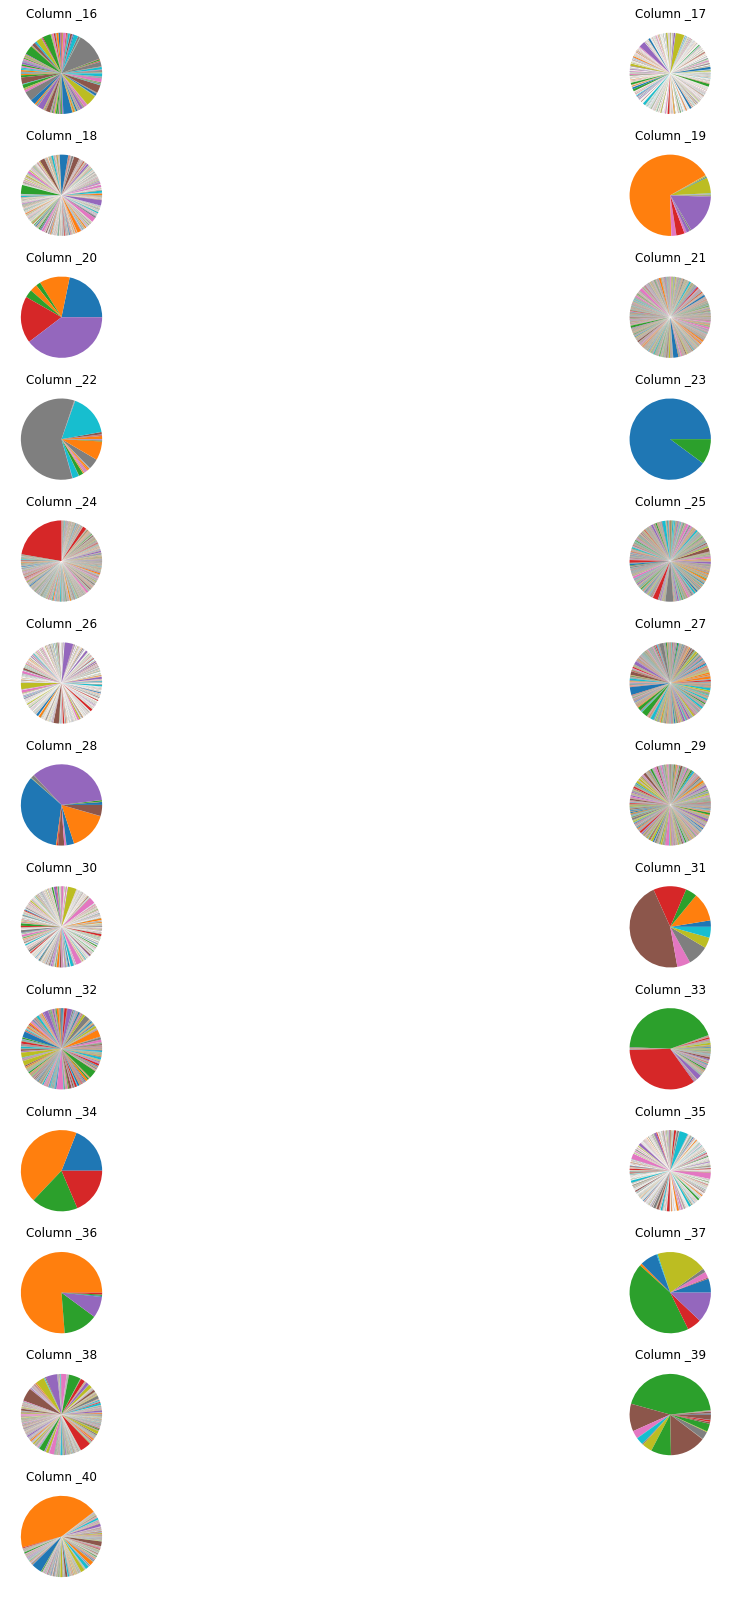

In [17]:
#pull a sample
df2=traindf2.sample(False,0.02)
#create a pie chart per categorical column
plt.figure(figsize=(20, 40))
for i in range(16,41):
    test =df2.groupby("_"+str(i)).count().toPandas()
    plt.subplot(18, 2, i-15, title='Column _'+str(i))
    plt.pie(test['count'])
plt.show()

After reviewing the pie charts, we know we have ALOT of categorical values which will become features in our model.  It looks like we should consider removing categorical fields with more than 10,000 unique values - this would include columns 17, 18, 21, 24, 26, 29, 30, 35, 38, 40. Removing columns with too many unique features helps to prevent overfitting, as well as helps with the scalability of the model for decision tree and logistic regression. 10,000 was chosen as a starting point, and reduces the number of columns by ~ 1/3. Future work could play with this feature engineering metric. 


In [82]:
print('Unique values for each feature:')
for col in  traindf2.columns:
    c=traindf2.select(col).distinct().count()
    print(f'{col}: {c} ')

Unique values for each feature:
label: 2 
_2: 649 
_3: 9364 
_4: 14746 
_5: 490 
_6: 476707 
_7: 11618 
_8: 4142 
_9: 1373 
_10: 7275 
_11: 13 
_12: 169 
_13: 407 
_14: 1376 
_15: 32 
_16: 583 
_17: 10131227 
_18: 2202608 
_19: 305 
_20: 24 
_21: 12517 
_22: 633 
_23: 3 
_24: 93145 
_25: 5683 
_26: 8351593 
_27: 3194 
_28: 27 
_29: 14992 
_30: 5461306 
_31: 10 
_32: 5652 
_33: 2173 
_34: 4 
_35: 7046547 
_36: 18 
_37: 15 
_38: 286181 
_39: 105 
_40: 142572 


#### III.C Correlation
Continuing in our quest to reduce features, we turn our attention to highly correlated numeric values. If two values are highly correlated, including both values can create noise and lower-quality models. For example, users who visit a certain website may correlate with users who open spam emails. Including both these features could be redundant if there is a high correlation rate.

In [69]:
traindf2_cl = traindf2.fillna('0')
col_names = 'label', '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12', '_13', '_14'
traindf2_cl = traindf2_cl.select('label', '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12', '_13', '_14').fillna(0)

from pyspark.mllib.stat import Statistics
import pandas as pd

features = traindf2_cl.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
print(corr_df)


          label        _2        _3        _4        _5        _6        _7  \
label  1.000000  0.104088  0.044435  0.009770 -0.055718 -0.076539 -0.055812   
_2     0.104088  1.000000  0.034108  0.038390  0.081069 -0.068993 -0.058315   
_3     0.044435  0.034108  1.000000 -0.008308 -0.081530 -0.006260 -0.013320   
_4     0.009770  0.038390 -0.008308  1.000000  0.042022 -0.003412  0.005079   
_5    -0.055718  0.081069 -0.081530  0.042022  1.000000 -0.094468  0.015560   
_6    -0.076539 -0.068993 -0.006260 -0.003412 -0.094468  1.000000  0.002158   
_7    -0.055812 -0.058315 -0.013320  0.005079  0.015560  0.002158  1.000000   
_8     0.085156  0.477780  0.025422  0.000373  0.038521 -0.056270 -0.027060   
_9    -0.027436  0.097048 -0.028035  0.045087  0.504384 -0.109468  0.022175   
_10    0.024072  0.068316 -0.004732 -0.000465  0.194364 -0.068310  0.186576   
_11    0.191717  0.465176  0.035712 -0.003791  0.157900 -0.148043 -0.124605   
_12    0.158357  0.304534  0.032760 -0.005823  0.063

It looks like there is little correlation between the label and any of the variables individually, the maximum is about 0.6. Therefore, we did not removed any columns due to high correlation. 


We also spent some time investigating how many unique features were not very frequent.  We found that if we only kept features that occurred more than 10,000 times in a column, then we would limit the one-hot-encoding to 7877 columns or 7877 unique features.  If we limited this value to only values that appeared more than 100 times, then we would have 184,224 unique values.  We used this information later to determine what our threshold should be for binning together various features into an "other" category in our later data pre-processing step.

In [39]:
keep_columns = keep_col_df.select("_c15").filter("cnt>10000").filter("_c15 <> 'null'").rdd.flatMap(lambda x: x).collect()
len(keep_columns)

7877

In [40]:
keep_columns2 = keep_col_df.select("_c15").filter("cnt>100").filter("_c15 <> 'null'").rdd.flatMap(lambda x: x).collect()
len(keep_columns2 )

184224

## IV. Implementation

Many iterations of models were run during our testing phase, and a summary of those results are in a table below.  The code in the following sections highlights the data preparation performed and as well as the models run on both sample and full data sets. 

#### Evaluation - Log Loss

Most Click Through Analytics use log loss as their evaluation technique, and we did as well. Instead of considering a pure accuracy metric, this this method takes into account how sure the algorithm was when predicting an accurate Y variable through a calculation involving the log of probability. The goal is to minimize the log loss. This provides a more nuanced approach and provides more certainty to the predictions, compared to a harsh yes/no accuracy.  

$y log(p) + (1-y) log(1-p)$

http://wiki.fast.ai/index.php/Log_Loss

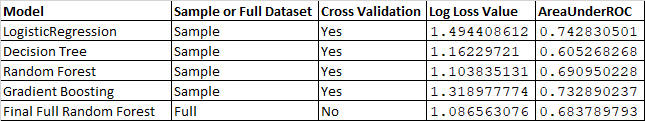



The results table above highlights a summary of our work. The Logistic regression and Random Forest for the full dataset are down below, the code for the rest is in the appendix. The first 4 models were run on a sample dataset. The last model, our chosen model, was Random Forest and was run on the full 44 million record data set (which was first split into training and test). As can be seen, the lowest log losses were for both random forest models. However, it is interesting to note that the highest area under the curve was for the logistic regression model we built. While we did optimize our chosen evaluation method, more work needs to be done to understand the relationship between this metric and others. 


### IV.A Data Preparation

Steps taken on the data fed to the decision tree and random forest model:
    
1.  Remove fields that contain more than 10,000 unique features
2.  Use the fields we identified in our EDA to consolidate low-frequency values into a single value
3.  Remove fields that had many null values - anything missing more than 20% of the data set

Steps taken on the data for Logistic Regression (our baseline model):
1.  Remove fields that contain more than 10,000 unique features
2.  One Hot Encode the Categorical Fields
3.  For Logistic Regression, we will set all the nulls to 0 and added a column to indicate that was done

These feature engineering steps will help with scalability/runnability and generalizability of our models. Logistic regression has specific needs that differ from decision tree models, and less feature engineering was done to optimize this model as it was our baseline anyway.  

In [ ]:
#1a. This removes the columns with more than 10k features
to_drop =['_17', '_18', '_21', '_24', '_26', '_29', '_30', '_35', '_38', '_40']
rawdf2 = rawdf2.drop(*to_drop)

In [ ]:
#1b. This removes the columns with more than 20% nulls.  This is about 40% of the rest of the columns.
to_drop =['_4', '_5', '_14', '_7', '_33', '_34', '_39', '_2', '_11', '_36', '_13', '_15']
raw_dropped = rawdf2.drop(*to_drop)

In [ ]:
# 2 Consolidate low-frequency values
#some of these imports may be repeats
from pyspark.sql.functions import col

import pyspark as ps
from pyspark.sql import SQLContext, Column
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, count as sparkcount, when, lit
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline
import json 

def withMeta(self, alias, meta):
    sc = ps.SparkContext._active_spark_context
    jmeta = sc._gateway.jvm.org.apache.spark.sql.types.Metadata
    return Column(getattr(self._jc, "as")(alias, jmeta.fromJson(json.dumps(meta))))

def group_low_freq(df,inColumns,threshold=.01,group_text='other'):
    """
    Index string columns and group all observations that occur in less then a threshold% of the rows in df per column.
    :param df: A pyspark.sql.dataframe.DataFrame
    :param inColumns: String columns that need to be indexed
    :param group_text: String to use as replacement for the observations that need to be grouped.
    """
    total = df.count()
    for string_col in inColumns:
        # Apply string indexer
        pipeline = Pipeline(stages=[StringIndexer(inputCol=string_col, outputCol="ix_"+string_col, handleInvalid="skip")])
        df = pipeline.fit(df).transform(df)

        # Calculate the number of unique elements to keep
        n_to_keep = df.groupby(string_col).agg((sparkcount(string_col)/total).alias('perc')).filter(col('perc')>threshold).count()

        # If elements occur below (threshold * number of rows), replace them with n_to_keep.
        this_meta = df.select('ix_' + string_col).schema.fields[0].metadata
        if n_to_keep != len(this_meta['ml_attr']['vals']):  
            this_meta['ml_attr']['vals'] = this_meta['ml_attr']['vals'][0:(n_to_keep+1)]
            this_meta['ml_attr']['vals'][n_to_keep] = group_text    
            df = df.withColumn('ix_'+string_col,when(col('ix_'+string_col)>=n_to_keep,lit(n_to_keep)).otherwise(col('ix_'+string_col)))

        # add the new column with correct metadata, remove original.
        df = df.withColumn('ix_'+string_col, withMeta(col('ix_'+string_col), "", this_meta))

    return df


#https://stackoverflow.com/questions/48566982/how-to-efficiently-group-levels-with-low-frequency-counts-in-a-high-cardinality


categoricalColumns = ['_3','_6','_8','_9','_10','_12','_16','_19','_20','_22','_23','_25','_27','_28','_31','_32','_37']


df = group_low_freq(raw_dropped,categoricalColumns,0.0002)    

ix_cols = [x for x in df.columns if 'ix_' in x]
for string_col in ix_cols:    
    idx_to_string = IndexToString(inputCol=string_col, outputCol=string_col[3:]+'grouped')
    df = idx_to_string.transform(df)

#The grouped output column is the one that will have the rare variables replaced

In [ ]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())
trainingData.write.parquet('gs://final_smh21/data/train.parquet')
testData.write.parquet('gs://final_smh21/data/test.parquet')
trainingData=spark.read.parquet('gs://final_smh21/data/train.parquet')
testData=spark.read.parquet('gs://final_smh21/data/test.parquet')

In [37]:
# Reference: https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = [ '_16grouped','_19grouped','_20grouped','_22grouped','_23grouped','_25grouped',
                      '_27grouped','_28grouped','_31grouped','_32grouped','_37grouped']

stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [38]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="label", outputCol="_label")
stages += [label_stringIdx]

In [39]:
# Transform all features into a vector using VectorAssembler
numericCols = ['_3',  '_6',  '_8', '_9', '_10', '_12']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [40]:

# Run the stages as a Pipeline. This puts the data through all of the feature transformations we described in a single call.
 
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(trainingData)
preppedDataDF = pipelineModel.transform(trainingData)

In [54]:
# Keep relevant columns
cols = trainingData.columns
selectedcols = ["_label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)
display(dataset)

from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="_label", featuresCol="features")

# Train model with Training Data
rfModel = rf.fit(dataset)

DataFrame[_label: double, features: vector, label: int, _3: int, _6: int, _8: int, _9: int, _10: int, _12: int, _16: string, _19: string, _20: string, _22: string, _23: string, _25: string, _27: string, _28: string, _31: string, _32: string, _37: string, ix__3: double, ix__6: double, ix__8: double, ix__9: double, ix__10: double, ix__12: double, ix__16: double, ix__19: double, ix__20: double, ix__22: double, ix__23: double, ix__25: double, ix__27: double, ix__28: double, ix__31: double, ix__32: double, ix__37: double, _3grouped: string, _6grouped: string, _8grouped: string, _9grouped: string, _10grouped: string, _12grouped: string, _16grouped: string, _19grouped: string, _20grouped: string, _22grouped: string, _23grouped: string, _25grouped: string, _27grouped: string, _28grouped: string, _31grouped: string, _32grouped: string, _37grouped: string]

In [72]:
sampledf = traindf2.sample(False,0.02)

sampledf.write.format("parquet").save("gs://w261-final-nathan/data/sample.parquet")
sampledf=spark.read.parquet("gs://w261-final-nathan/data/sample.parquet")


sampledf.printSchema()
#Identify null records, record that they were null and reset values to 0
sampledf = sampledf.select('label', 
              '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12', '_13', '_14', '_15', 
              '_16', '_17', '_18', '_19', '_20', '_21', '_22', '_23', '_24', '_25', 
              '_26', '_27', '_28', '_29', '_30', '_31', '_32', '_33', '_34', '_35', 
              '_36', '_37', '_38', '_39', '_40',
               F.isnull(sampledf._16).alias("null_16"),
               F.isnull(sampledf._17).alias("null_17"),
               F.isnull(sampledf._18).alias("null_18"),
               F.isnull(sampledf._19).alias("null_19"),
               F.isnull(sampledf._20).alias("null_20"),
               F.isnull(sampledf._21).alias("null_21"),
               F.isnull(sampledf._22).alias("null_22"),
               F.isnull(sampledf._23).alias("null_23"),
               F.isnull(sampledf._24).alias("null_24"),
               F.isnull(sampledf._25).alias("null_25"),
               F.isnull(sampledf._26).alias("null_26"),
               F.isnull(sampledf._27).alias("null_27"),
               F.isnull(sampledf._28).alias("null_28"),
               F.isnull(sampledf._29).alias("null_29"),
               F.isnull(sampledf._30).alias("null_30"),
               F.isnull(sampledf._31).alias("null_31"),
               F.isnull(sampledf._32).alias("null_32"),
               F.isnull(sampledf._33).alias("null_33"),
               F.isnull(sampledf._34).alias("null_34"),
               F.isnull(sampledf._35).alias("null_35"),
               F.isnull(sampledf._36).alias("null_36"),
               F.isnull(sampledf._37).alias("null_37"),
               F.isnull(sampledf._38).alias("null_38"),
               F.isnull(sampledf._39).alias("null_39"),
               F.isnull(sampledf._40).alias("null_40")              
             ) 

sampledf2 = sampledf.na.fill('0')
sampledf2 = sampledf2.na.fill(0)

root
 |-- label: integer (nullable = true)
 |-- _2: integer (nullable = true)
 |-- _3: integer (nullable = true)
 |-- _4: integer (nullable = true)
 |-- _5: integer (nullable = true)
 |-- _6: integer (nullable = true)
 |-- _7: integer (nullable = true)
 |-- _8: integer (nullable = true)
 |-- _9: integer (nullable = true)
 |-- _10: integer (nullable = true)
 |-- _11: integer (nullable = true)
 |-- _12: integer (nullable = true)
 |-- _13: integer (nullable = true)
 |-- _14: integer (nullable = true)
 |-- _15: integer (nullable = true)
 |-- _16: string (nullable = true)
 |-- _17: string (nullable = true)
 |-- _18: string (nullable = true)
 |-- _19: string (nullable = true)
 |-- _20: string (nullable = true)
 |-- _21: string (nullable = true)
 |-- _22: string (nullable = true)
 |-- _23: string (nullable = true)
 |-- _24: string (nullable = true)
 |-- _25: string (nullable = true)
 |-- _26: string (nullable = true)
 |-- _27: string (nullable = true)
 |-- _28: string (nullable = true)
 |-- _

In [9]:
# Reference: https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
#categoricalColumns = ["_"+str(i) for i in range(15,41)]
categoricalColumns = ['_15', '_16','_19','_20','_22','_23','_25','_27','_28','_31','_32','_33','_34','_36','_37','_39']


stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [10]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="label", outputCol="_label")
stages += [label_stringIdx]

In [11]:
# Transform all features into a vector using VectorAssembler
numericCols = ["_"+str(i) for i in range(2,15)]

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [12]:
# Run the stages as a Pipeline. This puts the data through all of the feature transformations we described in a single call.
from pyspark.ml.classification import LogisticRegression
  
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(sampledf2)
preppedDataDF = pipelineModel.transform(sampledf2)

In [13]:
# Fit model to prepped data
lrModel = LogisticRegression().fit(preppedDataDF)

# ROC for training data
display(lrModel, preppedDataDF, "ROC")

LogisticRegression_4fb8801224a3b430434b

DataFrame[label: int, _2: int, _3: int, _4: int, _5: int, _6: int, _7: int, _8: int, _9: int, _10: int, _11: int, _12: int, _13: int, _14: int, _15: int, _16: string, _19: string, _20: string, _22: string, _23: string, _25: string, _27: string, _28: string, _31: string, _32: string, _33: string, _34: string, _36: string, _37: string, _39: string, null_16: boolean, null_17: boolean, null_18: boolean, null_19: boolean, null_20: boolean, null_21: boolean, null_22: boolean, null_23: boolean, null_24: boolean, null_25: boolean, null_26: boolean, null_27: boolean, null_28: boolean, null_29: boolean, null_30: boolean, null_31: boolean, null_32: boolean, null_33: boolean, null_34: boolean, null_35: boolean, null_36: boolean, null_37: boolean, null_38: boolean, null_39: boolean, null_40: boolean, _15Index: double, _15classVec: vector, _16Index: double, _16classVec: vector, _19Index: double, _19classVec: vector, _20Index: double, _20classVec: vector, _22Index: double, _22classVec: vector, _23Ind

'ROC'

In [ ]:
# Keep relevant columns
cols = sampledf2.columns # list of all columns
selectedcols = ["_label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)
display(dataset)

DataFrame[_label: double, features: vector, label: int, _2: int, _3: int, _4: int, _5: int, _6: int, _7: int, _8: int, _9: int, _10: int, _11: int, _12: int, _13: int, _14: int, _15: int, _16: string, _19: string, _20: string, _22: string, _23: string, _25: string, _27: string, _28: string, _31: string, _32: string, _33: string, _34: string, _36: string, _37: string, _39: string, null_16: boolean, null_17: boolean, null_18: boolean, null_19: boolean, null_20: boolean, null_21: boolean, null_22: boolean, null_23: boolean, null_24: boolean, null_25: boolean, null_26: boolean, null_27: boolean, null_28: boolean, null_29: boolean, null_30: boolean, null_31: boolean, null_32: boolean, null_33: boolean, null_34: boolean, null_35: boolean, null_36: boolean, null_37: boolean, null_38: boolean, null_39: boolean, null_40: boolean]

In [3]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

641697
274386


### IV.B Logistic Regression - sample data set

In [16]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="_label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [17]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

In [18]:
# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose age & occupation
selected = predictions.select("_label", "prediction", "probability")
selected.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.76486286497117...|
|   0.0|       0.0|[0.73972765903881...|
|   0.0|       0.0|[0.73367849167311...|
|   0.0|       1.0|[0.40723117397791...|
|   0.0|       0.0|[0.59194585432776...|
|   0.0|       0.0|[0.59915631747561...|
|   0.0|       0.0|[0.76049530473866...|
|   0.0|       0.0|[0.61235375402537...|
|   0.0|       0.0|[0.59271820375159...|
|   0.0|       1.0|[0.49138893312841...|
+------+----------+--------------------+
only showing top 10 rows



In [19]:
selected.select('probability').show(10, False)

+----------------------------------------+
|probability                             |
+----------------------------------------+
|[0.7648628649711713,0.23513713502882877]|
|[0.7397276590388101,0.2602723409611899] |
|[0.7336784916731153,0.2663215083268846] |
|[0.40723117397791575,0.5927688260220842]|
|[0.5919458543277645,0.40805414567223547]|
|[0.5991563174756143,0.40084368252438574]|
|[0.7604953047386634,0.23950469526133653]|
|[0.6123537540253703,0.38764624597462966]|
|[0.592718203751595,0.40728179624840494] |
|[0.49138893312841436,0.5086110668715856]|
+----------------------------------------+
only showing top 10 rows



In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.7423245818479793

In [22]:
# As we indicate 3 values for regParam, 3 values for maxIter, and 3 values for elasticNetParam, this grid will have 3 x 3 x 3 = 27 parameter settings for CrossValidator to choose from. 
# We will create a 5-fold cross validator.
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [23]:
#running
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [24]:
# Use test set to measure the accuracy of our model on new data
predictions_cv = cvModel.transform(testData)

In [25]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions_cv)

0.7428305007372072

In [26]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]  # convert numpy type to float, and to tuple
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
weightsDF.show(10)

+--------------------+
|      Feature Weight|
+--------------------+
|-0.21097318243701146|
|-0.24416673253790314|
|  -0.410204743247671|
|  -0.261376178382862|
|-0.13460228321618228|
|-0.34449454538522445|
|  -2.030954766414997|
|   1.526019573012764|
| -1.9887306452181313|
|  1.4078802326511164|
+--------------------+
only showing top 10 rows



In [27]:
# View best model's predictions and probabilities of each prediction class
selected_cv = predictions_cv.select("_label", "prediction", "probability")
selected_cv.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.75278815059901...|
|   0.0|       0.0|[0.72932940001464...|
|   0.0|       0.0|[0.72099265654382...|
|   0.0|       1.0|[0.40225493172292...|
|   0.0|       0.0|[0.59640288471647...|
|   0.0|       0.0|[0.60324582884606...|
|   0.0|       0.0|[0.74609875126230...|
|   0.0|       0.0|[0.61348376811528...|
|   0.0|       0.0|[0.59205809658193...|
|   0.0|       1.0|[0.49611941707219...|
+------+----------+--------------------+
only showing top 10 rows



In [64]:
selected_cv.write.format("parquet").save("gs://w261-final-nathan/result/lr.parquet")

In [28]:
# Save the best model
bestModel_lr = cvModel.bestModel
# bestModel_lr.write().overwrite().save("gs://final_smh21/model/best_lr_model")
bestModel_lr.write().overwrite().save("gs://w261-final-nathan/model/best_lr_model")

In [73]:
#calculate log loss
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import pyspark.sql.functions as f

def calculateLogLoss(selected):
    firstelement=udf(lambda v:float(v[0]),FloatType())
    selected2 = selected.select('_label','prediction', firstelement('probability').alias('probability'))


    selected3 = (
        selected2.withColumn(
            'logloss'
            , -f.col('_label')*f.log(f.col('probability')) - (1.-f.col('_label'))*f.log(1.-f.col('probability'))
        )
    )

    logloss = selected3.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']
    
    return logloss

In [52]:
# Log Loss for Logistic Regression
logloss = calculateLogLoss(selected_cv)
print ('Log Loss for Logistic Regression: {}'.format(logloss))

Log Loss for Logistic Regression: 1.4944086117128101


In [53]:
# Log Loss for Decision Tree
logloss = calculateLogLoss(selected_cv_dt)
print ('Log Loss for Decision Tree: {}'.format(logloss))

Log Loss for Logistic Regression: 1.1622972104741207


In [54]:
#  Log Loss for Random Forest
logloss = calculateLogLoss(selected_cv_rf)
print ('Log Loss for Random Forest: {}'.format(logloss))

Log Loss for Logistic Regression: 1.1038351312460377


In [55]:
#  Log Loss for Gradient Boosted Trees
logloss = calculateLogLoss(selected_cv_gbt)
print ('Log Loss for Gradient Boosted: {}'.format(logloss))

Log Loss for Logistic Regression: 1.3189777742640296


## IV.C Random Forest -  Full Dataset

Random Forest had the lowest log loss on our sample measurements with minimal feature pruning. It was the model we chose to run on the full dataset. Below is the data processing and modeling steps. Some choices we made for our algorithm design: 

1. We used the default number of trees for algorithm, which is 20. We would like to look into using more trees in future work, but had to balance time and resources
2. We used Gini classification because we have categorical variables included, and it does best with those
3. Other settings within the Random Forest Pyspark classifier were left at default, this is another avenue for future work



In [ ]:
#1a. This removes the columns with more than 10k features
to_drop =['_17', '_18', '_21', '_24', '_26', '_29', '_30', '_35', '_38', '_40']
rawdf2 = rawdf2.drop(*to_drop)

In [ ]:
#1b. This removes the columns with more than 20% nulls.  This is about 40% of the rest of the columns.
to_drop =['_4', '_5', '_14', '_7', '_33', '_34', '_39', '_2', '_11', '_36', '_13', '_15']
raw_dropped = rawdf2.drop(*to_drop)

In [ ]:
# 2 Consolidate low-frequency values
#some of these imports may be repeats
from pyspark.sql.functions import col

import pyspark as ps
from pyspark.sql import SQLContext, Column
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, count as sparkcount, when, lit
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline
import json 

def withMeta(self, alias, meta):
    sc = ps.SparkContext._active_spark_context
    jmeta = sc._gateway.jvm.org.apache.spark.sql.types.Metadata
    return Column(getattr(self._jc, "as")(alias, jmeta.fromJson(json.dumps(meta))))

def group_low_freq(df,inColumns,threshold=.01,group_text='other'):
    """
    Index string columns and group all observations that occur in less then a threshold% of the rows in df per column.
    :param df: A pyspark.sql.dataframe.DataFrame
    :param inColumns: String columns that need to be indexed
    :param group_text: String to use as replacement for the observations that need to be grouped.
    """
    total = df.count()
    for string_col in inColumns:
        # Apply string indexer
        pipeline = Pipeline(stages=[StringIndexer(inputCol=string_col, outputCol="ix_"+string_col, handleInvalid="skip")])
        df = pipeline.fit(df).transform(df)

        # Calculate the number of unique elements to keep
        n_to_keep = df.groupby(string_col).agg((sparkcount(string_col)/total).alias('perc')).filter(col('perc')>threshold).count()

        # If elements occur below (threshold * number of rows), replace them with n_to_keep.
        this_meta = df.select('ix_' + string_col).schema.fields[0].metadata
        if n_to_keep != len(this_meta['ml_attr']['vals']):  
            this_meta['ml_attr']['vals'] = this_meta['ml_attr']['vals'][0:(n_to_keep+1)]
            this_meta['ml_attr']['vals'][n_to_keep] = group_text    
            df = df.withColumn('ix_'+string_col,when(col('ix_'+string_col)>=n_to_keep,lit(n_to_keep)).otherwise(col('ix_'+string_col)))

        # add the new column with correct metadata, remove original.
        df = df.withColumn('ix_'+string_col, withMeta(col('ix_'+string_col), "", this_meta))

    return df


#https://stackoverflow.com/questions/48566982/how-to-efficiently-group-levels-with-low-frequency-counts-in-a-high-cardinality

categoricalColumns = ['_3','_6','_8','_9','_10','_12','_16','_19','_20','_22','_23','_25','_27','_28','_31','_32','_37']


df = group_low_freq(raw_dropped,categoricalColumns,0.0002)    

ix_cols = [x for x in df.columns if 'ix_' in x]
for string_col in ix_cols:    
    idx_to_string = IndexToString(inputCol=string_col, outputCol=string_col[3:]+'grouped')
    df = idx_to_string.transform(df)

#The grouped output column is the one that will have the rare variables replaced

In [ ]:
### Randomly split data into training and test sets. set seed for reproducibility and save the data for future speed
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())
trainingData.write.parquet('gs://final_smh21/data/train.parquet')
testData.write.parquet('gs://final_smh21/data/test.parquet')
trainingData=spark.read.parquet('gs://final_smh21/data/train.parquet')
testData=spark.read.parquet('gs://final_smh21/data/test.parquet')

In [ ]:
# Reference: https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
#categoricalColumns = ["_"+str(i) for i in range(15,41)]
#categoricalColumns = ['_15', '_16','_19','_20','_22','_23','_25','_27','_28','_31','_32','_33','_34','_36','_37','_39']


categoricalColumns = [ '_16grouped','_19grouped','_20grouped','_22grouped','_23grouped','_25grouped',
                      '_27grouped','_28grouped','_31grouped','_32grouped','_37grouped']

stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [ ]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="label", outputCol="_label")
stages += [label_stringIdx]

In [ ]:
# Transform all features into a vector using VectorAssembler
#numericCols = ["_"+str(i) for i in range(2,15)]
numericCols = ['_3',  '_6',  '_8', '_9', '_10', '_12']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:

# Run the stages as a Pipeline. This puts the data through all of the feature transformations we described in a single call.
 
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(trainingData)
preppedDataDF = pipelineModel.transform(trainingData)

In [ ]:
# Keep relevant columns
cols = trainingData.columns
selectedcols = ["_label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)


In [61]:
display(dataset)


DataFrame[_label: double, features: vector, label: int, _3: int, _6: int, _8: int, _9: int, _10: int, _12: int, _16: string, _19: string, _20: string, _22: string, _23: string, _25: string, _27: string, _28: string, _31: string, _32: string, _37: string, ix__3: double, ix__6: double, ix__8: double, ix__9: double, ix__10: double, ix__12: double, ix__16: double, ix__19: double, ix__20: double, ix__22: double, ix__23: double, ix__25: double, ix__27: double, ix__28: double, ix__31: double, ix__32: double, ix__37: double, _3grouped: string, _6grouped: string, _8grouped: string, _9grouped: string, _10grouped: string, _12grouped: string, _16grouped: string, _19grouped: string, _20grouped: string, _22grouped: string, _23grouped: string, _25grouped: string, _27grouped: string, _28grouped: string, _31grouped: string, _32grouped: string, _37grouped: string]

In [ ]:

from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="_label", featuresCol="features")

# Train model with Training Data
rfModel = rf.fit(dataset)

In [62]:
#reformat test data
partialPipeline = Pipeline().setStages(stages)
testpipelineModel = partialPipeline.fit(testData)
testpreppedDataDF = pipelineModel.transform(testData)
# Keep relevant columns
cols = testData.columns
selectedcols = ["_label", "features"] + cols
testdataset = testpreppedDataDF.select(selectedcols)

In [68]:
# Make predictions on test data using the Transformer.transform() method.
predictions_rf_full = rfModel.transform(testdataset)

In [75]:
# View model's predictions and probabilities of each prediction class
selected_rf_full = predictions_rf_full.select("_label", "prediction", "probability")
selected_rf_full.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.74316050574383...|
|   0.0|       0.0|[0.70653437441020...|
|   0.0|       0.0|[0.69836198378517...|
|   0.0|       0.0|[0.70332377473273...|
|   0.0|       0.0|[0.69615415717738...|
|   0.0|       0.0|[0.65338387432742...|
|   0.0|       0.0|[0.68028845915727...|
|   0.0|       0.0|[0.70340248511798...|
|   0.0|       0.0|[0.73775168460480...|
|   0.0|       0.0|[0.74343165369386...|
+------+----------+--------------------+
only showing top 10 rows



In [77]:
# Evaluate model
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_rf_full = BinaryClassificationEvaluator()
evaluator_rf_full.evaluate(predictions_rf_full)

0.6837897934216225

In [84]:
# Evaluate model
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_rf_full = BinaryClassificationEvaluator()
evaluator_rf_full.evaluate(predictions_rf_full)

0.6837897934216228

In [85]:
selected_rf = predictions_rf_full.select("_label", "prediction", "probability")
selected_rf.show(10)
logloss = calculateLogLoss(selected_rf)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.74316050574383...|
|   0.0|       0.0|[0.70653437441020...|
|   0.0|       0.0|[0.69836198378517...|
|   0.0|       0.0|[0.70332377473273...|
|   0.0|       0.0|[0.69615415717738...|
|   0.0|       0.0|[0.65338387432742...|
|   0.0|       0.0|[0.68028845915727...|
|   0.0|       0.0|[0.70340248511798...|
|   0.0|       0.0|[0.73775168460480...|
|   0.0|       0.0|[0.74343165369386...|
+------+----------+--------------------+
only showing top 10 rows



In [87]:
print(logloss)

1.0865630756323839


In [88]:
predictions_rf_full.write.parquet('gs://final_smh21/data/rf_predictions.parquet')
selected_rf.write.parquet('gs://final_smh21/rf_predictions.parquet')

## V. Course Concepts

To delete from kyle "Correctly identifies 3-5 course concepts that are relevant to this algorithm. Discussion demonstrates understanding of the chosen concepts 
and addresses how"

● scalability / time complexity / I/O vs Memory
● functional programming / higher order functions / map reduce paradigm
● bias variance tradeoff / model complexity / regularization
● associative/commutative operations
● race conditions / barrier synchronization / statelessness
● the shuffle / combiners / local aggregation
● order inversion pattern / composite keys
● total order sort / custom partitioning
● broadcasting / caching / DAGs / lazy evaluation
● GD - convex optimization / Batch vs stochastic
● sparse representation (pairs vs stripes)
● preserving the graph structure / additional payloads
● One Hot Encoding / vector embeddings / feature selection (***)
● normalization
● assumptions (for different algorithms - for example OLS vs Trees)
● implications of iterative algorithms in Hadoop M/R vs Spark


This course was critical in being able to implement a ML algorithm of this scale. Some of the course concepts we utilized are listed below. 

* The data is much too large to be all held in memory, so we knew some of the processing would involve reading and writing from disk. We chose parquet as the data type to write to and then read from. Parquet is columnar storage, and which has many advantages when working with Spark dataframes: limits I/O operations, allows access to specific columns (features, in our case), and allows type specific encoding and compression. There are some drawbacks to parquet, like it being bad to write due to the large amount of meta data and its un-appendability. However, we will be reading the dataset more after pre-processing than writing, and all appending was done in spark before it was written out so these concerns are mitigated. Checkpointing the data into parquet files also allowed for easier sharing of the notebook, and helped minimize damages if spark cluster blew up while we were testing our models. 
* Feature selection was also a key concept we utilized. With this much data, it is important to only include the data that is relevant to making the best model one can, and avoiding wasting resources on processing features that don't create benefit. 
* Also, the two models that we ran in this project had different requirements and different approaches needed to be taken in setting up the correct datasets to run each model on. The logistic regression model required One Hot encoding of the categorical features, which in turn spawned a feature for every distinct variable. This was a concern when considering scalability, and played into which features we included in the dataset and which model we ended up choosing. All of these steps were not required for Decision Tree and Random Forest modeling - it is a rather robust in that it handles null values quite well, does not require normalized data for evaluation, and also does not require that the categorical variables be One Hot Encoded. 
* More theory for supporting our choice of Random Forest was mentioned in our introduction, which is the bias variance tradeoff - Random Forest does a good job of reducing bias without increasing variance by much.  
* Also, decision trees and Random Forest are very iterative models to build, and utilizing Spark allowed us to optimize a lot of that process that would have to have been very explicitly coded in Hadoop. 

Sources:

https://www.tutorialspoint.com/spark_sql/spark_sql_parquet_files.htm

## VI.  If we had more time...

1. Build FFM in Spark

"Factorization helps in representing approximately the same relationship between the target and predictors using a lower dimension dense matrix. In this article, I discuss Factorization Machines(FM) and Field Aware Factorization Machines(FFM) which allows us to take advantage of factorization in a regression/classification problem with an implementation using python."

"A linear or a logistic modeling technique is great and does well in a variety of problems but the drawback is that the model only learns the effect of all variables or features individually rather than in combination."

https://www.analyticsvidhya.com/blog/2018/01/factorization-machines/?utm_campaign=buffer&utm_content=buffer81252&utm_medium=social&utm_source=twitter.com

2. More Feature Engineering
3. Tune Parameters for Random Forest - increase the number of trees and run cross validation
4. Matrix Factorization

## APP.1 Decision Tree - sample set

In [30]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="_label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(trainingData)

# Make predictions on test data using the Transformer.transform() method.
predictions_dt = dtModel.transform(testData)

In [31]:
# View model's predictions and probabilities of each prediction class
selected_dt = predictions_dt.select("_label", "prediction", "probability")
selected_dt.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.76968978411267...|
|   0.0|       0.0|[0.76968978411267...|
|   0.0|       0.0|[0.76968978411267...|
|   0.0|       0.0|[0.67812966150315...|
|   0.0|       0.0|[0.67812966150315...|
|   0.0|       0.0|[0.79658030925078...|
|   0.0|       0.0|[0.76968978411267...|
|   0.0|       0.0|[0.67812966150315...|
|   0.0|       0.0|[0.76968978411267...|
|   0.0|       0.0|[0.56201263589276...|
+------+----------+--------------------+
only showing top 10 rows



In [32]:
# Evaluate our Decision Tree model with BinaryClassificationEvaluator.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate model
evaluator_dt = BinaryClassificationEvaluator()
evaluator_dt.evaluate(predictions_dt)

0.4624579915899342

In [33]:
# Entropy and the Gini coefficient are the supported measures of impurity for Decision Trees. 
# This is Gini by default. Changing this value is simple, model.setImpurity("Entropy").
dt.getImpurity()

'gini'

In [34]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid_dt = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             .addGrid(dt.maxBins, [20, 40, 80])
             .build())

In [35]:
# Create 5-fold CrossValidator
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_dt, numFolds=5)

# Run cross validations
cvModel_dt = cv_dt.fit(trainingData)
# Takes ~5 minutes

In [36]:
# Use test set to measure the accuracy of our model on new data
predictions_cv_dt = cvModel_dt.transform(testData)

In [37]:

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator_dt.evaluate(predictions_cv_dt)

0.6052682675623707

In [38]:
# View Best model's predictions and probabilities of each prediction class
selected_cv_dt = predictions_cv_dt.select("_label", "prediction", "probability")
selected_cv_dt.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.64118218832099...|
|   0.0|       0.0|[0.64118218832099...|
|   0.0|       0.0|[0.64118218832099...|
|   0.0|       0.0|[0.64118218832099...|
|   0.0|       0.0|[0.64118218832099...|
|   0.0|       0.0|[0.81148475053870...|
|   0.0|       0.0|[0.64118218832099...|
|   0.0|       0.0|[0.64118218832099...|
|   0.0|       0.0|[0.64118218832099...|
|   0.0|       0.0|[0.64118218832099...|
+------+----------+--------------------+
only showing top 10 rows



In [63]:
selected_cv_dt.write.format("parquet").save("gs://w261-final-nathan/result/dt.parquet")

In [39]:
# Save the best model
bestModel_dt = cvModel_dt.bestModel
bestModel_dt.write().overwrite().save("gs://w261-final-nathan/model/best_dt_model")

## APP.2 Random Forest - sample data set

In [40]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="_label", featuresCol="features")

# Train model with Training Data
rfModel = rf.fit(trainingData)

In [41]:
# Make predictions on test data using the Transformer.transform() method.
predictions_rf = rfModel.transform(testData)

In [42]:

# View model's predictions and probabilities of each prediction class
selected_rf = predictions_rf.select("_label", "prediction", "probability")
selected_rf.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.71829446408187...|
|   0.0|       0.0|[0.73140111752028...|
|   0.0|       0.0|[0.74189277551481...|
|   0.0|       0.0|[0.73234944326128...|
|   0.0|       0.0|[0.73711547597359...|
|   0.0|       0.0|[0.75989253044764...|
|   0.0|       0.0|[0.74023369074791...|
|   0.0|       0.0|[0.73145370876651...|
|   0.0|       0.0|[0.71855535306531...|
|   0.0|       0.0|[0.70241369684448...|
+------+----------+--------------------+
only showing top 10 rows



In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator_rf = BinaryClassificationEvaluator()
evaluator_rf.evaluate(predictions_rf)

0.6879618562886349

In [44]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid_rf = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

In [45]:
# Create 5-fold CrossValidator
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_rf, numFolds=5)

# Run cross validations.  This can take a while since it is training over 20 trees!
cvModel_rf = cv_rf.fit(trainingData)

In [46]:
# Use test set here so we can measure the accuracy of our model on new data
predictions_cv_rf = cvModel_rf.transform(testData)

In [47]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator_rf.evaluate(predictions_cv_rf)

0.6909502278688711

In [48]:
# View Best model's predictions and probabilities of each prediction class
selected_cv_rf = predictions_cv_rf.select("_label", "prediction", "probability")
selected_cv_rf.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.72245662260733...|
|   0.0|       0.0|[0.72858611901285...|
|   0.0|       0.0|[0.73908246946696...|
|   0.0|       0.0|[0.73095644232050...|
|   0.0|       0.0|[0.74132485557052...|
|   0.0|       0.0|[0.75464070100611...|
|   0.0|       0.0|[0.74353789193336...|
|   0.0|       0.0|[0.73470838023503...|
|   0.0|       0.0|[0.71525815882183...|
|   0.0|       0.0|[0.70713213167538...|
+------+----------+--------------------+
only showing top 10 rows



In [62]:
selected_cv_rf.write.format("parquet").save("gs://w261-final-nathan/result/rf.parquet")

In [49]:
# Save the best model
bestModel_rf = cvModel_rf.bestModel
bestModel_rf.write().overwrite().save("gs://w261-final-nathan/model/best_rf_model")

## APP.3 Gradient-Boosted Trees (GBTs) - sample data set

GBTs train one tree at a time, where each new tree helps to correct errors made by previously trained trees. With each tree added, the model becomes even more expressive. Was run on only a sample data set, it took a very long time. Future work could include more time working on scalabilty and with ore resources.

In [4]:
from pyspark.ml.classification import GBTClassifier
# Create an initial Gradient-Boosted Trees model.
gbt = GBTClassifier(labelCol="_label", featuresCol="features", maxIter=10)
# Train model with Training Data
gbtModel = gbt.fit(trainingData)

In [5]:
# Make predictions on test data using the Transformer.transform() method.
predictions_gbt = gbtModel.transform(testData)

In [6]:
# View model's predictions and probabilities of each prediction class
selected_gbt = predictions_gbt.select("_label", "prediction", "probability")
selected_gbt.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.78695591931270...|
|   0.0|       0.0|[0.71485423564820...|
|   0.0|       0.0|[0.78501008500608...|
|   0.0|       0.0|[0.54237874312838...|
|   0.0|       0.0|[0.67266779190050...|
|   0.0|       0.0|[0.75301528316576...|
|   0.0|       0.0|[0.72093522916305...|
|   0.0|       0.0|[0.75763993993204...|
|   0.0|       0.0|[0.71456733975700...|
|   0.0|       1.0|[0.45779534069112...|
+------+----------+--------------------+
only showing top 10 rows



In [7]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator_gbt = BinaryClassificationEvaluator()
evaluator_gbt.evaluate(predictions_gbt)

0.7191767136559201

In [10]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid_gbt = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

In [11]:
# Create 5-fold CrossValidator
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid_gbt, evaluator=evaluator_gbt, numFolds=5)

# Run cross validations.  This can take a while since it is training over 20 trees!
cvModel_gbt = cv_gbt.fit(trainingData)

In [12]:
# Use test set here so we can measure the accuracy of our model on new data
predictions_cv_gbt = cvModel_gbt.transform(testData)

In [13]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator_gbt.evaluate(predictions_cv_gbt)

0.7328902366093857

In [14]:
# View Best model's predictions and probabilities of each prediction class
selected_cv_gbt = predictions_cv_gbt.select("_label", "prediction", "probability")
selected_cv_gbt.show(10)

+------+----------+--------------------+
|_label|prediction|         probability|
+------+----------+--------------------+
|   0.0|       0.0|[0.79946989543350...|
|   0.0|       0.0|[0.73859408626868...|
|   0.0|       0.0|[0.80371768576610...|
|   0.0|       1.0|[0.49611004884264...|
|   0.0|       0.0|[0.68088297726171...|
|   0.0|       0.0|[0.77826850113320...|
|   0.0|       0.0|[0.73283773373603...|
|   0.0|       0.0|[0.75422843865731...|
|   0.0|       0.0|[0.71377531427829...|
|   0.0|       1.0|[0.46488612052447...|
+------+----------+--------------------+
only showing top 10 rows



In [58]:
selected_cv_gbt.write.format("parquet").save("gs://w261-final-nathan/result/gbt.parquet")

In [15]:
# Save the best model
bestModel_gbt = cvModel_gbt.bestModel
bestModel_gbt.write().overwrite().save("gs://w261-final-nathan/model/best_gbt_model")